# Introduction to Quantum Machine Learning

In [19]:
import numpy as np
import matplotlib.pyplot as plt

from qibo.models import Circuit
from qibo import gates, hamiltonians, set_backend
from qibo.optimizers import optimize

set_backend("numpy")

[Qibo 0.1.14|INFO|2023-07-20 18:34:02]: Using numpy backend on /CPU:0


## 1. A look back to quantum circuits

In particular we will focus on parametric circuits, because we want to use them as machine learning model.

In [57]:
# define a circuit
c = Circuit(1)

# we can add parametric gates
c.add(gates.RY(q=0, theta=0))
c.add(gates.RZ(q=0, theta=0))
c.add(gates.M(0))

MeasurementResult(qubits=(0,), nshots=0)

In [58]:
# circuit drawing
print(c.draw())

# and circuit information
print(f"\n{c.summary()}")

# circuit execution
final_state = c.execute(nshots=1000)
print(f"\nfinal state: {final_state}")

# set a new angle in the RX rotation
nparams = len(c.get_parameters())
print(f"\nnparams: {nparams}")
print(f"params: {c.get_parameters()}")

# set a new parameter
c.set_parameters(np.random.randn(nparams))
print(f"new params: {c.get_parameters()}")

# circuit execution with new params
final_state = c.execute(nshots=1000)
print(f"\nfinal state: {final_state}")


q0: ─RY─RZ─M─

Circuit depth = 3
Total number of gates = 3
Number of qubits = 1
Most common gates:
ry: 1
rz: 1
measure: 1

final state: (1+0j)|0>

nparams: 2
params: [(0,), (0,)]
new params: [(-1.13797922769341,), (0.6650998413947715,)]

final state: (0.79629-0.27502j)|0> + (-0.50926-0.17589j)|1>


In [59]:
# set hamiltonian
h = hamiltonians.Z(nqubits=1) 
print(f"Hamiltonian:\n{h.matrix}")

# expectation
print(f"\nExpectation: {h.expectation(c.execute().state())}")

Hamiltonian:
[[-1.-0.j -0.-0.j]
 [-0.-0.j  1.-0.j]]

Expectation: -0.41942979148688225


## 2. Play with parametric gates

In [60]:
x_angles = np.linspace(-2*np.pi, 2*np.pi, 100)
y_angles = np.linspace(0, np.pi, 100)

expectations = []

for x, y in zip(x_angles, y_angles):
    c.set_parameters([x, y])
    expectations.append(h.expectation(c.execute().state()))

In [61]:
def plot_expectations(energies):
    """Plot energy in function of the epochs"""
    plt.figure(figsize=(8,5))
    plt.title("Energy over training")
    plt.plot(energies, color="purple", alpha=0.7, lw=2, label="Energy values")
    plt.xlabel(r"$\theta$")
    plt.ylabel("E")
    plt.grid(True)
    plt.legend()
    plt.show()

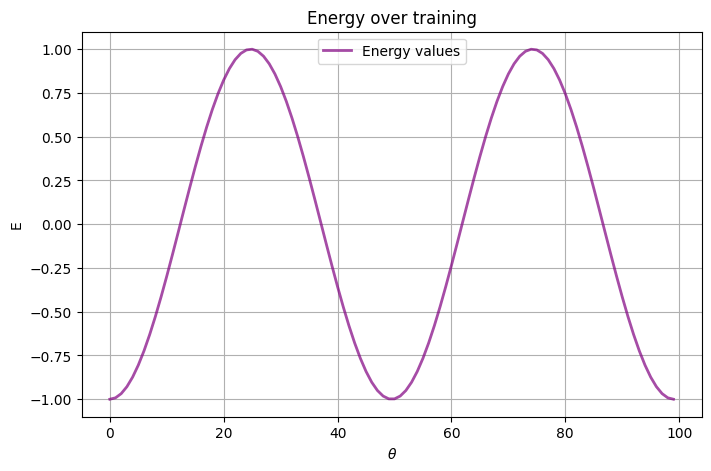

In [62]:
plot_expectations(expectations)

## 3. Injecting information into a circuit

We can define a big class of parametric circuits, which can be called Variational 
Quantum Circuits (VQC), in whose parametric gates we can inject both data and 
variational parameters!

<img src="figures/vqc.png" width="600" height="600" align="center"/>

One way to embed data in QML is to define some uploading layer into the circuit and then to 
repeat the uploading of the data many times [1]. 

In [73]:
# define a circuit composed of nlayers

def build_vqc(nqubits, nlayers):
    """Build VQC composed of nqubits and nlayers"""
    
    # init circuit
    vqc = Circuit(nqubits)
    
    # loop over layers
    for l in range(nlayers):
        # loop over qubits
        for q in range(nqubits):
            vqc.add(gates.RY(q=q, theta=0))
            vqc.add(gates.RY(q=q, theta=0))
            vqc.add(gates.RZ(q=q, theta=0))
            vqc.add(gates.RZ(q=q, theta=0))
        # we add an entangling channel at the end of each layer
        for q in range(0, nqubits-1):
            vqc.add(gates.CNOT(q0=q, q1=q+1))
        vqc.add(gates.CNOT(q0=nqubits-1, q1=0))
    # we add one measurement gate for each qubit
    vqc.add(gates.M(*range(nqubits)))
    
    return vqc

In [77]:
nqubits = 3
nlayers = 2

vqc = build_vqc(nqubits=nqubits, nlayers=nlayers)
print(vqc.draw())

q0: ─RY─RY─RZ─RZ─o───X─RY─RY─RZ─RZ─o───X─M─
q1: ─RY─RY─RZ─RZ─X─o─|─RY─RY─RZ─RZ─X─o─|─M─
q2: ─RY─RY─RZ─RZ───X─o─RY─RY─RZ─RZ───X─o─M─


In [78]:
# define a way for uploading both data and parameters

def inject_data(circuit, nlayers, parameters, x):
    """Inject data and params into the circuit."""
    
    # empty list of parameters
    params = []
    # we keep track of the index
    index = 0

    # loop over layers
    for l in range(nlayers):
        # loop over qubits
        for q in range(circuit.nqubits):
            # we fill the first RY with param * x
            params.append(parameters[index] * x)
            # bias
            params.append(parameters[index + 1])
            # we fill the first RZ with param * x
            params.append(parameters[index + 2] * x)
            # bias
            params.append(parameters[index + 3])
    
    # set the new parameters affected by x into the circuit and return it
    circuit.set_parameters(params)
    return circuit

In [82]:
# set random parameters inside the circuit
old_params = np.random.randn(len(vqc.get_parameters()))
print(old_params)

[ 0.52733588 -0.38468289  0.27788179 -0.02222785 -0.44080603 -0.31229212
  0.88844495  0.38875427 -0.63352832  0.11717191  0.66890635 -0.56848388
  0.1396527   0.89773025  0.2223906  -1.28403551 -0.19989331  0.41176083
  0.26911774  1.29406767  0.58884731  0.86534905 -0.75654214 -0.74004477]


In [96]:
# inject data
x = 2

vqc = fill_circuit(vqc, nlayers, old_params, x)

new_params = vqc.get_parameters()

print("Check the even params are doubled:\n")
for p in range(6):
    print(f"Old value: {old_params[p]:.4}\t New value: {new_params[p][0]:.4}")

Check the even params are doubled:

Old value: 0.5273	 New value: 1.055
Old value: -0.3847	 New value: -0.3847
Old value: 0.2779	 New value: 0.5558
Old value: -0.02223	 New value: -0.02223
Old value: -0.4408	 New value: 1.055
Old value: -0.3123	 New value: -0.3847


## 4. A snapshot of quantum machine learning

<img src="figures/qml.jpg" width="1000" height="1000" align="center"/>


## 5. Exercise: tune circuit parameters to get a target value

Define:
1. a 1-qubit circuit with two parametrized gates: an RY followed by an RZ, with a measurement gate in the end;
2. an 1-qubit hamiltonian to be used as target observable: in particular I suggest you to use a pauli Z;
3. initialize the parameters of the circuit with random values using numpy;
4. use `qibo.optimizers.optimize` module with `method="cma"` to find the optimized params and passing as loss function the one suggested some cells below;
5. compute the expected value of the hamiltonian on the state we obtain by executing the circuit filled with the best parameters returned by the CMA optimizer;

In [106]:
# set model
model = Circuit(1)
model.add(gates.RY(q=0, theta=0))
model.add(gates.RZ(q=0, theta=0))
model.add(gates.M(0))

# set hamiltonian
hamiltonian = hamiltonians.Z(1) 

In [107]:
def mse(parameters, hamiltonian=hamiltonian, model=model, target=0.5):
    """Mean Squared Error with y_target=0.5 given model and hamiltonian."""
    expectation = ham.expectation(model.execute().state())
    return (expectation-target)**2

def loss(parameters):
    """Many optimizers need a loss function which depends only on parameters."""
    model.set_parameters(parameters)
    return mse(parameters)

In [108]:
print(model.draw())
print(hamiltonian.matrix)

q0: ─RY─RZ─M─
[[-1.-0.j -0.-0.j]
 [-0.-0.j  1.-0.j]]


In [109]:
par = np.random.randn(2)
model.set_parameters(par)

In [110]:
result = optimize(loss, par, method="cma")

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=987636, Thu Jul 20 19:12:02 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 2.315012067646236e-01 1.0e+00 1.47e+00  1e+00  1e+00 0:00.0
    2     12 1.773371466287665e-05 1.2e+00 1.17e+00  9e-01  1e+00 0:00.0
    3     18 2.358280821240272e-03 1.1e+00 9.43e-01  7e-01  7e-01 0:00.0
   57    342 4.541821246918180e-19 7.4e+03 3.39e-04  2e-08  2e-04 0:00.1
termination on tolfun=1e-11 (Thu Jul 20 19:12:02 2023)
final/bestever f-value = 1.169333e-24 1.169333e-24 after 343/343 evaluations
incumbent solution: [-2.094395102394444, -0.05575209459008816]
std deviation: [2.097730152583196e-08, 0.00015665254175743185]


In [111]:
result[1]

array([-2.0943951 , -0.05575209])

In [112]:
model.set_parameters(result[1])

In [113]:
ham.expectation(model.execute().state())

0.5000000000010814

## Question: can you tackle any target value using this setup?